### Imports

In [206]:
import numpy as np
import random
import os
import time
import pickle
from tqdm import trange, tqdm
import gc

import torch
import torch.optim as optim
from datasets import load_dataset

from transformers import BertTokenizer, BertModel, BertConfig
from xai_transformer import BertAttention, GammaParams, LNargsDetach, GammaNet, GammaParams
from utils import LayerNorm, flip

### Configuration

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [208]:
bert_config = BertConfig.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loadi

In [209]:
class SimpleConfig:
    hidden_size = bert_config.hidden_size
    all_head_size = bert_config.hidden_size
    num_attention_heads = bert_config.num_attention_heads
    attention_head_size = bert_config.hidden_size // bert_config.num_attention_heads
    n_blocks = 4
    n_classes = 2
    device = device
    train_mode = False
    detach_layernorm = True
    detach_mean = True
    detach_kq = True
    layer_norm_eps = 1e-5
    gamma_LN = 0.0
    gamma_AH = 0.0

config = SimpleConfig()

### Initializing models

In [210]:
hf_bert = BertModel.from_pretrained("bert-base-uncased")
hf_embeddings = hf_bert.embeddings

# Replacing layer norm with LayerNormImpl
hf_embeddings = hf_embeddings  # keep same object
hf_embeddings.LayerNorm = LayerNorm(bert_config.hidden_size, eps = bert_config.layer_norm_eps,
                                   args = LNargsDetach())

hf_embeddings = hf_embeddings.to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Some weights of the model check

In [211]:
model = BertAttention(config, hf_embeddings).to(device)
model.eval()
print("Model loaded successfully!")

Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm
Model loaded successfully!


In [212]:
pooled_dim = hf_embeddings.word_embeddings.weight.shape[1]
gamma_net = GammaNet(hidden_dim=64, n_blocks=config.n_blocks, pooled_dim=pooled_dim).to(device)
print("GammaNet created:", gamma_net)

GammaNet created: GammaNet(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
    (3): Sigmoid()
  )
)


In [213]:
print(f"GammaNet has a total of {sum(p.numel() for p in gamma_net.parameters())} trainable parameters")

GammaNet has a total of 49736 trainable parameters


In [214]:
gamma_net

GammaNet(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
    (3): Sigmoid()
  )
)

### Preparing data

In [215]:
ds = load_dataset("glue", "sst2")
val_ds = ds["validation"]
print("Validation size:", len(val_ds))

Validation size: 872


In [216]:
TRAIN_SAMPLES = 200
VAL_SAMPLES = 100

In [217]:
def dataset_iter(dataset, max_samples=None):
    cnt = 0
    for ex in dataset:
        enc = tokenizer(ex["sentence"], truncation=True, padding="max_length", max_length=64, return_tensors="pt")
        input_ids = enc["input_ids"].long()  # shape [1, seq_len]
        att_mask = enc["attention_mask"].long()
        label = int(ex["label"])
        yield input_ids.to(device), att_mask.to(device), label
        cnt += 1
        if max_samples is not None and cnt >= max_samples:
            break

In [218]:
train_iter = list(dataset_iter(val_ds, max_samples=TRAIN_SAMPLES))
val_iter = list(dataset_iter(val_ds, max_samples=VAL_SAMPLES))
print("Prepared train/val subsets:", len(train_iter), len(val_iter))

Prepared train/val subsets: 200 100


### Defining Hyperparameters and Helper functions

In [219]:
epochs = 1
lr = 1e-5
comp_weight = 10.0 # weight on completeness loss
auac_weight = 1.0 # weight on the AUAC proxy
gamma_reg = 1e-2
topk_frac = 0.1 # for AUAC proxy
exact_every = 200 # run exact flip eval every _ steps
do_exact_eval = True
save_path = "/mnt/data/gamma_net_results.pkl"

In [220]:
def get_pooled_embedding_from_embeds(input_ids):
    # produce embeddings and pooled CLS embedding
    with torch.no_grad():
        try:
            embeds_out = model.embeds(input_ids=input_ids)
        except TypeError:
            embeds_out = model.embeds(input_ids)
    pooled = embeds_out[:, 0, :].to(device)   # [1, hidden]
    return pooled

In [221]:
def mask_topk_by_R(input_ids, R_tensor, frac, pad_id=0):
    # R_tensor expected torch.Tensor or numpy-like vector; handle both
    if isinstance(R_tensor, torch.Tensor):
        R_np = R_tensor.detach().cpu().numpy().flatten()
    else:
        R_np = np.array(R_tensor).flatten()
    seq_len = input_ids.shape[1]
    k = max(1, int(seq_len * frac))
    topk_idx = np.argsort(-R_np)[:k]
    masked = input_ids.clone()
    masked[0, topk_idx] = pad_id
    return masked

In [222]:
history = {"step": [], "loss": [], "comp": [], "gamma_mean": [], "val_comp": [], "val_auac": [], "val_aumse": [],
           "gamma_AH": [], "gamma_LN": [], "raw_logit": [], "sumR": []}

step = 0

In [223]:
# Freeze Bert Weights
for p in model.parameters():
    p.requires_grad = False

# unfreeze GammaNet weights
for p in gamma_net.parameters():
    p.requires_grad = True

optimizer = optim.Adam(gamma_net.parameters(), lr=lr, weight_decay = 1e-4)

In [224]:
epoch = 0

In [225]:
print("Starting training loop...")
for epoch in range(epochs):
    random.shuffle(train_iter)
    for input_ids, att_mask, label in tqdm(train_iter, desc = f"Epoch {epoch+1}/{epochs}"):
        step += 1

        # DIFFERENTIABLE FORWARD
        res = model.forward_and_explain_differentiable(input_ids=input_ids, cl=label, gamma_net=gamma_net)

        logits = res["logits"]
        R_out = res["R"]
        gamma_AH = res["gamma_AH"]
        gamma_LN = res["gamma_LN"]

        if torch.isnan(logits).any():
            print("NAN in logits")
        if torch.isnan(R_out).any():
            print("NAN in R_out")
        if torch.isnan(gamma_AH).any():
            print("NAN in gamma_AH")
        if torch.isnan(gamma_LN).any():
            print("NAN in gamma_LN")

        # LOSSES
        target_logit = logits[0, label]
        sumR = R_out.sum()
        comp_loss = (target_logit - sumR).pow(2).mean()
        gamma_reg_term = (gamma_AH.mean() + gamma_LN.mean()) * 0.5

        # AUAC PROXY (NO GRAD)
        # === AUAC PROXY (NO GRAD) ===
        # === AUAC PROXY (NO GRAD) ===
        with torch.no_grad():
            masked_ids = mask_topk_by_R(input_ids, R_out, topk_frac, pad_id=tokenizer.pad_token_id)

            # Use a simple forward pass without explanation
            # First, add this simple forward method to your BertAttention class if not already there:
            masked_out = model.forward_simple(masked_ids)  # We'll create this method
            new_logit = float(masked_out['logits'][0, label].cpu().numpy())
            auac_proxy = float(target_logit.detach().cpu().numpy()) - new_logit

        # BACKPROP
        loss = comp_weight * comp_loss + gamma_reg * gamma_reg_term

        optimizer.zero_grad()
        loss.backward()

        # Debug: Check if gradients are flowing to GammaNet
        # print("\n[GRAD CHECK] Before clipping:")
        # for name, param in gamma_net.named_parameters():
        #     if param.grad is not None:
        #         print(f"  {name}: grad_norm = {param.grad.norm().item():.8f}")
        #     else:
        #         print(f"  {name}: NO GRADIENTS!")

        torch.nn.utils.clip_grad_norm_(gamma_net.parameters(), 1.0)
        optimizer.step()

        # LOGGING
        gmean = float(gamma_reg_term.detach().cpu().numpy())
        history["step"].append(step)
        history["loss"].append(float(loss.detach().cpu().numpy()))
        history["comp"].append(float(comp_loss.detach().cpu().numpy()))
        history["gamma_mean"].append(gmean)
        history["gamma_AH"].append(gamma_AH.detach().cpu().numpy())
        history["gamma_LN"].append(gamma_LN.detach().cpu().numpy())
        history["raw_logit"].append(float(target_logit.detach().cpu().numpy()))
        history["sumR"].append(float(sumR.detach().cpu().numpy()))

        if step % 20 == 0:
            print(f"step {step:5d} loss={loss.item():.4f} comp={comp_loss.item():.6f} auac_proxy={auac_proxy:.4f} gamma_mean={gmean:.4f}")

        torch.cuda.empty_cache()

    print(f"Epoch {epoch+1} completed; steps so far: {step}")

Starting training loop...


Epoch 1/1:  10%|█         | 20/200 [00:08<01:05,  2.76it/s]

step    20 loss=0.0975 comp=0.009269 auac_proxy=0.0740 gamma_mean=0.4818


Epoch 1/1:  20%|██        | 40/200 [00:16<01:18,  2.04it/s]

step    40 loss=99.4323 comp=9.942746 auac_proxy=0.0629 gamma_mean=0.4829


Epoch 1/1:  30%|███       | 60/200 [00:24<00:50,  2.76it/s]

step    60 loss=7.4786 comp=0.747378 auac_proxy=0.0221 gamma_mean=0.4843


Epoch 1/1:  40%|████      | 80/200 [00:32<00:45,  2.61it/s]

step    80 loss=34.9519 comp=3.494709 auac_proxy=-0.0306 gamma_mean=0.4858


Epoch 1/1:  50%|█████     | 100/200 [00:39<00:36,  2.75it/s]

step   100 loss=349.9907 comp=34.998581 auac_proxy=0.0684 gamma_mean=0.4869


Epoch 1/1:  60%|██████    | 120/200 [00:48<00:30,  2.62it/s]

step   120 loss=0.0055 comp=0.000063 auac_proxy=-0.1066 gamma_mean=0.4880


Epoch 1/1:  70%|███████   | 140/200 [00:56<00:26,  2.24it/s]

step   140 loss=1491.0774 comp=149.107254 auac_proxy=-0.0767 gamma_mean=0.4886


Epoch 1/1:  80%|████████  | 160/200 [01:03<00:14,  2.74it/s]

step   160 loss=1136.3169 comp=113.631203 auac_proxy=-0.0935 gamma_mean=0.4891


Epoch 1/1:  90%|█████████ | 180/200 [01:12<00:07,  2.65it/s]

step   180 loss=108.0205 comp=10.801558 auac_proxy=-0.0279 gamma_mean=0.4899


Epoch 1/1: 100%|██████████| 200/200 [01:19<00:00,  2.50it/s]

step   200 loss=41486.1445 comp=4148.614258 auac_proxy=-0.0262 gamma_mean=0.4909
Epoch 1 completed; steps so far: 200


## Analysis

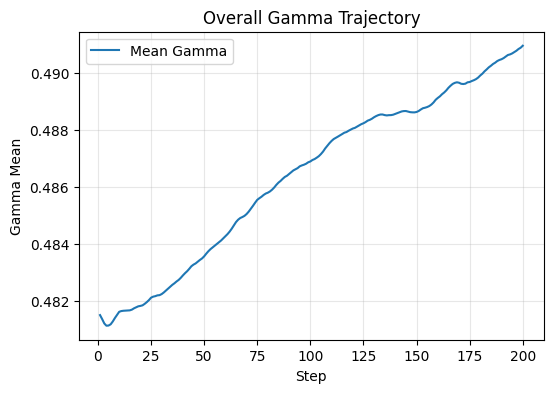

In [226]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history["step"], history["gamma_mean"], label="Mean Gamma")
plt.xlabel("Step")
plt.ylabel("Gamma Mean")
plt.title("Overall Gamma Trajectory")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


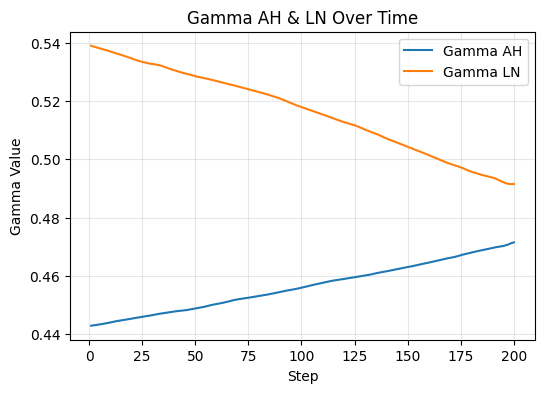

In [228]:
gamma_AH_means = [np.mean(x) for x in history["gamma_AH"]][::-1]
gamma_LN_means = [np.mean(x) for x in history["gamma_LN"]][::-1]

plt.figure(figsize=(6,4))
plt.plot(history["step"], gamma_AH_means, label="Gamma AH")
plt.plot(history["step"], gamma_LN_means, label="Gamma LN")
plt.xlabel("Step")
plt.ylabel("Gamma Value")
plt.title("Gamma AH & LN Over Time")
plt.grid(alpha=0.3)
plt.legend()
plt.show()